In [6]:
import os
import time
from pathlib import Path
import shutil
import numpy as np
import random
from matplotlib import pyplot as plt
import cv2
from commonfunctions import show_images

In [357]:
N = len(next(os.walk('./data/'))[1])            #N is the number of test cases in data folder (discussion).
M = 100                                         #M is the number of randomly generated test cases 

# Read dataset Metadata

In [358]:
f_dataset = open('./forms.txt', 'r')
Lines = f_dataset.readlines()
writers = []
for i in range(672):
    writers.append(list())

for line in Lines:
    if line[0] != '#':
        writers[int(line.split()[1])].append(line.split()[0])
        
#print(writers)    
f_dataset.close()

# Generate testcases from dataset

In [359]:
tests_writers = []                              #Array to keep the writer of the test image
path = "./test/"
number_of_writers_per_testcase = 3
number_of_images_per_writer = 2
#If folder does not exist create it
if not os.path.exists(path):
    Path(path).mkdir(parents=True, exist_ok=True)

#If folder already exists delete it to generate new test cases
else:
    shutil.rmtree(path)
    Path(path).mkdir(parents=True, exist_ok=True)

#Generate M test cases from the dataset
for i in range(M):
    path = "./test/"
    if i < 9:
        path = path + str(0) + str(i+1)
    else:
        path = path + str(i+1)  
        
    #Create folder for each testcase    
    Path(path).mkdir(parents=True, exist_ok=True)


    #Pick 3 random writers for each test case
    random_writers = []                                                 #Picked writers for a testcase
    while len(random_writers) < number_of_writers_per_testcase:
        W = random.randint(0,len(writers) - 1)                          #Pick random writer
        if not W in random_writers:                                     #Check that writer is not already picked
            if len(writers[W]) > number_of_images_per_writer:           #Check that writer has at least 3 images
                random_writers.append(W)
    
    random_images = []                                                  #All the picked images in the testset
    for j in range(number_of_writers_per_testcase):
        writer_path = path + "/" + str(j + 1)
        Path(writer_path).mkdir(parents=True, exist_ok=True)            #Create folder for each writer
        
        #Pick 2 random images for each writer
        random_images_per_writer = []                                   #Picked images per writer
        while len(random_images_per_writer) < 2:
            I = random.randint(0,len(writers[random_writers[j]]) - 1)              #Pick a random image by the writer
            if not writers[random_writers[j]][I] in random_images_per_writer:      #Check the image is not already picked
                random_images_per_writer.append(writers[random_writers[j]][I])
                random_images.append(writers[random_writers[j]][I])
        
        #Copy the picked images from the dataset folder to testcases
        shutil.copy2("./dataset/" + random_images_per_writer[0] + ".png", writer_path + "/1.png")
        shutil.copy2("./dataset/" + random_images_per_writer[1] + ".png", writer_path + "/2.png")
        
        #shutil.copy2("./data/01/1/1.png", writer_path + "/1.png")
        #shutil.copy2("./data/01/1/1.png", writer_path + "/2.png")
        
        
    #Pick test image from the dataset
    T = random.randint(0, len(random_writers) - 1)                          #Pick the writer of the test image
    while True:
        T_img = random.randint(0, len(writers[random_writers[T]]) - 1)      #Pick the test image
        if not writers[random_writers[T]][T_img] in random_images:          #Check the test image is not in training images
            shutil.copy2("./dataset/" + writers[random_writers[T]][T_img] +".png", path + "/test.png")
            #shutil.copy2("./data/01/test.png", path + "/test.png")
            tests_writers.append(T)
            break

print(tests_writers)

[292, 315, 217, 456, 337, 199, 635, 209, 353, 193, 150, 25, 384, 330, 208, 241, 0, 347, 272, 549, 19, 125, 286, 385, 355, 113, 108, 13, 300, 392, 273, 349, 339, 349, 393, 130, 586, 334, 346, 340, 112, 339, 545, 635, 247, 338, 173, 567, 61, 286, 274, 291, 63, 273, 132, 388, 286, 109, 346, 345, 288, 132, 357, 151, 287, 131, 131, 60, 340, 13, 117, 583, 117, 338, 114, 155, 353, 285, 203, 60, 551, 129, 203, 126, 292, 344, 583, 62, 193, 131, 272, 118, 355, 85, 340, 298, 199, 205, 150, 13]


In [459]:
def horizontalProjection(img):
    h, w = img.shape
    sumRows = []
    for j in range(h):
        row = img[j:j+1, 0:w]
        sumRows.append(int(np.sum(row)/255))
    return sumRows

In [616]:
def extract_hand_written(img):
    """
    This function returns original cropped image and dilated cropped image 
    for the handwritten part only and exclude any unused parts.
    """
    # Extract grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    # Apply binary thresholding using otsu's method to inverse the background and content color.
    thresh_inv = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
    # DEBUG: show_images([thresh_inv], ["Thresholding"]) 
    
    # Apply noise removal.
    #blur = cv2.GaussianBlur(thresh_inv,(7,7),0)
    blur = cv2.blur(thresh_inv,(7,7))
    #DEBUG: show_images([blur],["blur image"])
    
    # Apply thresholding for better and more general output.
    binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    #DEBUG: show_images([binary],["Binary image"])
    
    # Apply dilation to the image to make sure that horizontal lines are continuous.
    # Taking a matrix of size 4,2 as the kernel 
    kernel = np.ones((4,1), np.uint8) 
    img_dilation = cv2.dilate(binary, kernel, iterations=3)
    #DEBUG: show_images([img_dilation],["Dilation"])
    
    # Find lines by using contour
    # Find contours
    contours, hierarchy = cv2.findContours(img_dilation,  
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 

    # Find bounded rectangles surround the contours
    boundRect = [None]*len(contours)
    for i in range(len(contours)):
        boundRect[i] = cv2.boundingRect(contours[i])

    lines_pos = []
    height_diff = []
    i = 0
    while i < len(contours):
        # print(boundRect[i][2], boundRect[i][1])
        if boundRect[i][2] > 700:
            #cv2.rectangle(img, (int(boundRect[i][0]), int(boundRect[i][1])),(int(boundRect[i][0]+boundRect[i][2]),
              #int(boundRect[i][1]+boundRect[i][3])), (0,0,0), 2)
            #print(boundRect[i][1])
            lines_pos.append(boundRect[i][1])
            height_diff.append(boundRect[i][3])
            i += 10
        i += 1
    
    third = first = second = -1 
    max_index = mid_index = 0 
    for i in range(len(lines_pos)):
        if (lines_pos[i] > first):       
            third = second 
            second = first 
            first = lines_pos[i]
            max_index = i 
        elif (lines_pos[i] > second): 
            third = second 
            second = lines_pos[i] 
            mid_index = i
        elif (lines_pos[i] > third): 
            third = lines_pos[i] 
            
    # Take the line before hand written text directly.
    first_crop_line_height = lines_pos[mid_index] + height_diff[mid_index]
    # Take the line after hand written text directly.
    second_crop_line_height = np.max(lines_pos) 
    
    # print(first_crop_line_height+10, second_crop_line_height-10)
    # Crop the original image and the dilated image
    segIm = np.copy(img_dilation[first_crop_line_height+10:second_crop_line_height-10,:])
    segIm_original = np.copy(img[first_crop_line_height+10:second_crop_line_height-10,:])
    #DEBUG:show_images([segIm, segIm_original],["Segmented", "Segmented 2"])
    
    return segIm, segIm_original

In [617]:
def detect_sentences(segIm, segIm_original):
    """
    This function detect sentences and return a list of detected sentences.
    """
    show_images([segIm],["Before"])
    # Apply erosion to remove noise.
    kernel = np.ones((3,5), np.uint8) 
    img_erosion = cv2.erode(segIm, kernel, iterations=3) 
    # DEBUG:show_images([img_erosion], ["After erosion"]) 

    # Apply dilation to connect sentence togther as one block
    # Taking a matrix of size 3,10 as the kernel 
    kernel = np.ones((2, 20), np.uint8) 
    img_dilation = cv2.dilate(img_erosion, kernel, iterations=11)
    # DEBUG:
    show_images([img_dilation], ["After dilation"])

    # Find contours
    contours, hierarchy = cv2.findContours(img_dilation,  
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 

    # Find bounded rectangles surround the contours
    boundRect = [None]*len(contours)
    for i in range(len(contours)):
        boundRect[i] = cv2.boundingRect(contours[i])
        
    number_of_countours = 0
    sentences = []

    # Loop on the contours and crop each sentence
    i = len(contours) - 1
    while i >= 0:
        difference_in_width = boundRect[i][2]
        difference_in_height = boundRect[i][3]
        if(difference_in_width > 250 and difference_in_height > 50):
            #print(boundRect[i])
            number_of_countours += 1
            #cv2.rectangle(segIm_original, (int(boundRect[i][0]), int(boundRect[i][1])),(int(boundRect[i][0]+boundRect[i][2]),
             #                                           int(boundRect[i][1]+boundRect[i][3])), (0,0,0), 2)
            initial_height = int(boundRect[i][1])-20
            if initial_height < 0:
                initial_height = 0
            seg_sentence = np.copy(segIm_original[initial_height:int(boundRect[i][1]) + difference_in_height,
                                                  int(boundRect[i][0]):int(boundRect[i][0]) + difference_in_width])
            sentences.append(seg_sentence)
            #DEBUG: show_images([cv2.cvtColor(seg_sentence, cv2.COLOR_BGR2RGB)], ["sentence"+str(number_of_countours)])
        i -= 1


    #show_images([img],["Image"])
    #show_images([img_dilation], ["After dilation"])
    #show_images([gray],["Grayscale"])
    #show_images([binary], ["Otsu thresholding"])
 
    #DEBUG:cv2.drawContours(segIm_original, contours, -1, (0, 0, 0), 3) 
    #DEBUG:show_images([segIm_original],["With contours"])
    return sentences

In [618]:
def preprocessing(img):
    """
    This function preprocess the image and return list of sentences.
    """
    
    # Extract hand written part
    segIm, segIm_original = extract_hand_written(img)
    #DEBUG: show_images([cv2.cvtColor(img, cv2.COLOR_BGR2RGB)],["Original Image"])
    # Apply noise removal.
    blur = cv2.blur(segIm_original,(7,7))
    # Extract sentences
    sentences = detect_sentences(segIm, segIm_original)
    
    return sentences
    

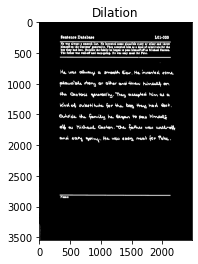

592 2797


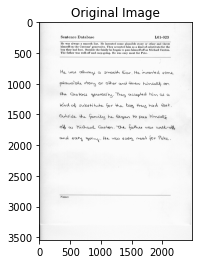

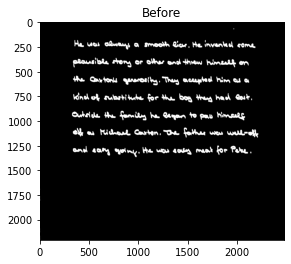

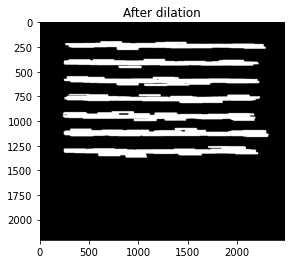

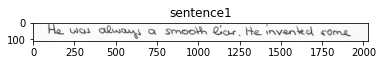

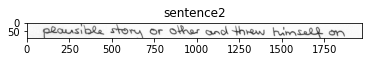

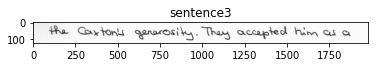

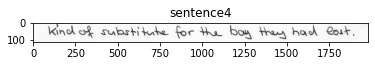

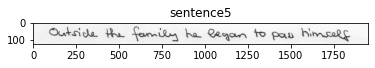

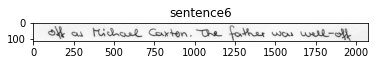

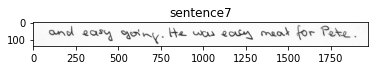

2.7463462352752686


In [619]:
img = cv2.imread('./test/01/3/2.png') 
start_time = time.time()
sentences = preprocessing(img)
end_time = time.time()

print(str(end_time - start_time))


# Program main loop

(331, 2792, 1798, 61)
(325, 652, 1798, 18)
(324, 301, 1800, 70)
680 2782


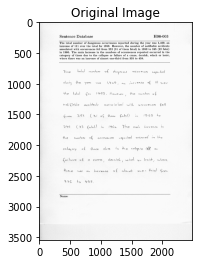

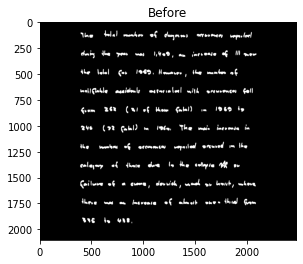

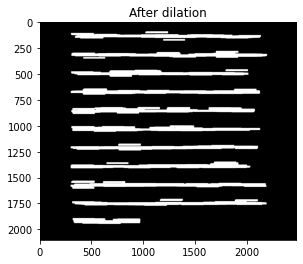

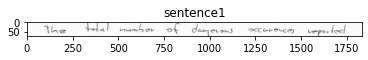

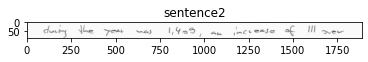

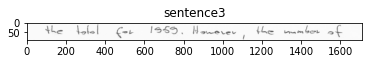

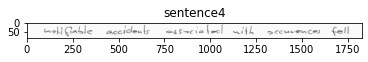

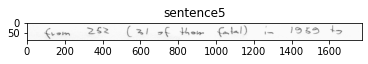

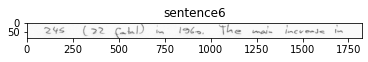

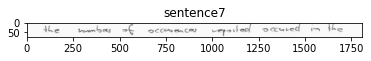

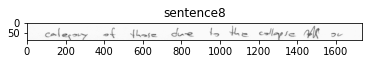

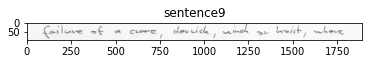

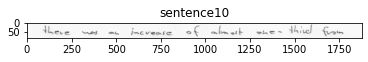

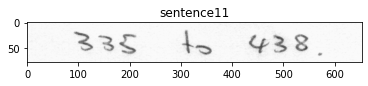

(348, 2792, 1800, 64)
(340, 552, 1800, 21)
(339, 301, 1801, 64)
583 2782


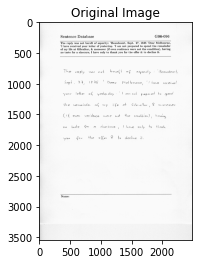

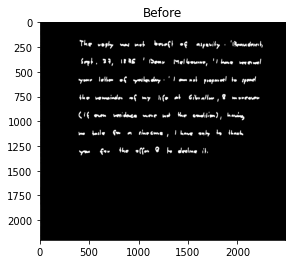

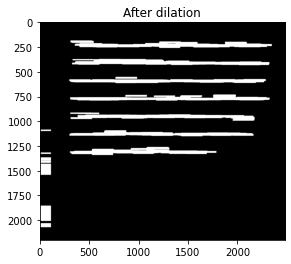

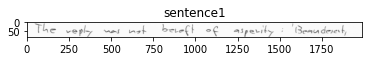

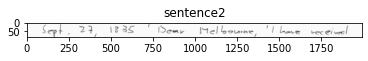

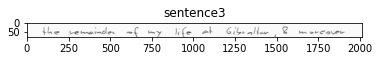

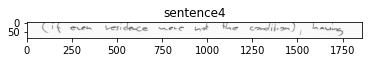

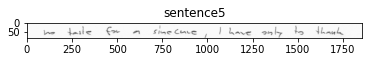

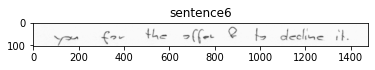

(350, 2802, 1805, 96)
(344, 656, 1803, 18)
(342, 304, 1804, 20)
684 2792


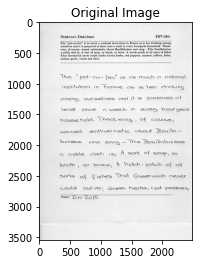

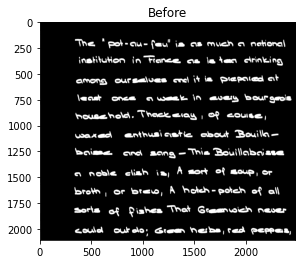

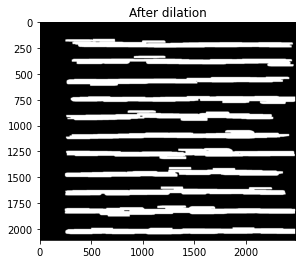

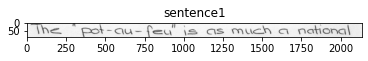

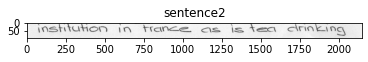

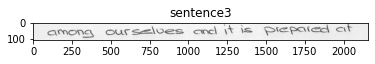

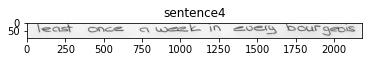

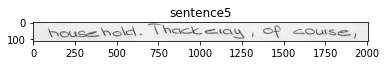

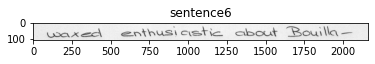

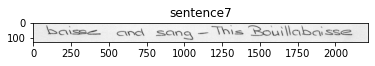

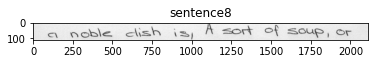

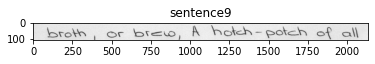

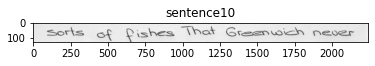

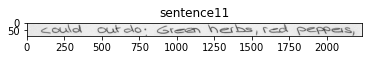

(358, 2803, 1804, 78)
(350, 557, 1803, 19)
(349, 305, 1804, 20)
586 2793


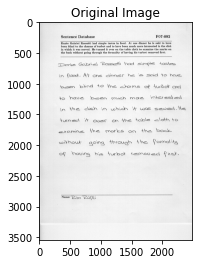

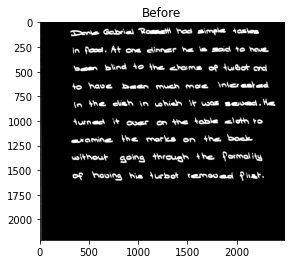

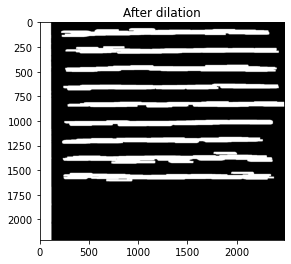

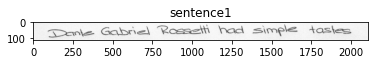

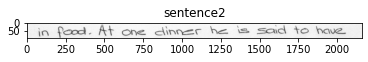

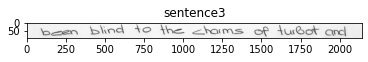

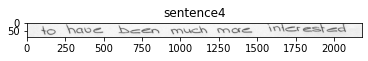

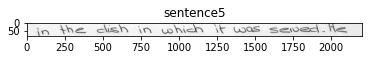

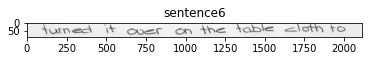

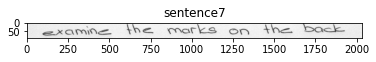

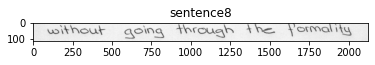

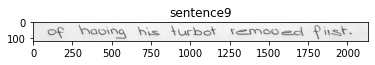

(368, 2790, 1799, 16)
(363, 550, 1800, 15)
(362, 300, 1800, 16)
575 2780


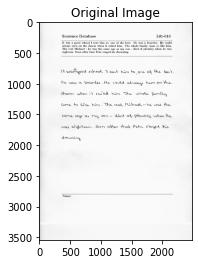

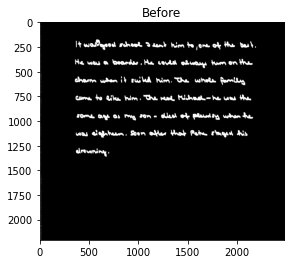

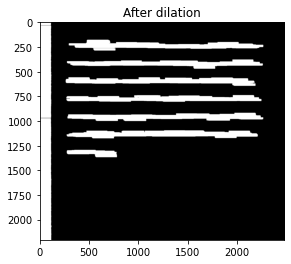

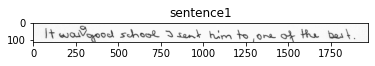

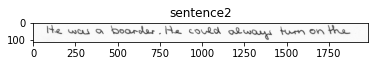

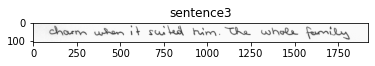

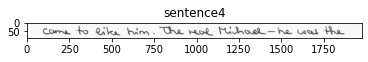

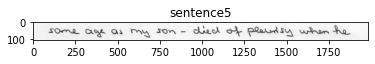

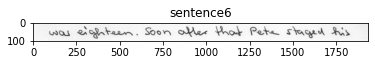

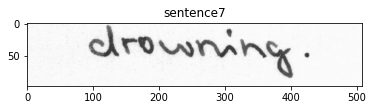

(337, 314, 1797, 18)
342 304


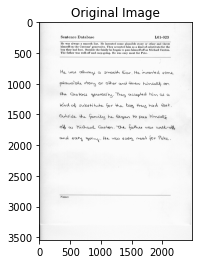

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-oduouqig\opencv\modules\imgproc\src\box_filter.dispatch.cpp:446: error: (-215:Assertion failed) !_src.empty() in function 'cv::boxFilter'


In [574]:
f_time = open('./output/time.txt', 'w')
f_results = open('./output/results.txt', 'w')

#program main loop
for i in range(2):
    path = "./test/"
    if i < 9:
        path = path + str(0) + str(i+1) + "/"
    else:
        path = path + str(i+1) + "/"
        
    w11 = cv2.imread(path + str(1) + "/1.PNG")
    sentences11 = preprocessing(w11)
    w12 = cv2.imread(path + str(1) + "/2.png")
    sentences12 = preprocessing(w12)
    w21 = cv2.imread(path + str(2) + "/1.png")
    sentences21 = preprocessing(w21)
    w22 = cv2.imread(path + str(2) + "/2.png")
    sentences22 = preprocessing(w22)
    w31 = cv2.imread(path + str(3) + "/1.png")
    sentences31 = preprocessing(w31)
    w32 = cv2.imread(path + str(3) + "/2.png")
    sentences32 = preprocessing(w32)

    test_im = cv2.imread(path + "test.png")
    sentences_test = preprocessing(test_im)
    
    start_time = time.time()
    #program logic here
      
    end_time = time.time()
    
    f_time.write(str(end_time - start_time) + "\n")
    
f_time.close()
f_results.close()